In [1]:
from integrators import contact as ic
from integrators.common import rk4, pad_and_cumsum

In [2]:
import numpy as np
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt

plt.style.use('fast') #alt: 'seaborn-white'

#plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['mathtext.fontset'] = "cm"

In [3]:
class Osc:
    def __init__(self, alpha):
        self.alpha = alpha

    def f(self, t):
        return alpha
    
    def V(self, q, t):
        return q**2/2
        
    def Vq(self, q, t):
        return q

In [4]:
upper_error_bound = lambda a, dt, p0, q0: dt**3/24 * abs(-4*q0*a+p0*(-4+a**2))
upper_error_bound_p = lambda a, dt, p0, q0: (dt**3)/24 * abs(4*p0*a+q0*(2+a**2))

def exact(a, t):
    discriminant = np.lib.scimath.sqrt(a**2 - 4)
    return np.real(
        np.exp(-1/2*(discriminant + a)*t)*(
            (discriminant + 2 + a)*np.exp(discriminant*t)
            + discriminant - 2 - a
        )/(2*discriminant))

def exactp(a, t):
    discriminant = np.lib.scimath.sqrt(a**2 - 4)
    return np.real(
        np.exp(-1/2*(discriminant + a)*t)*(
            2 + a + discriminant
            + (discriminant - 2 - a)*np.exp(discriminant*t)
        )/(2*discriminant))

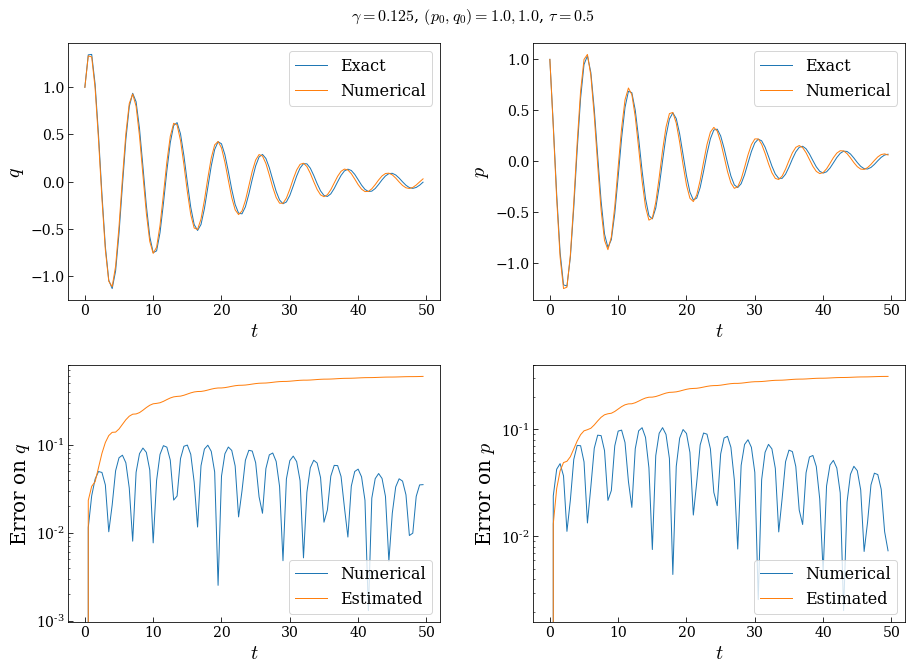

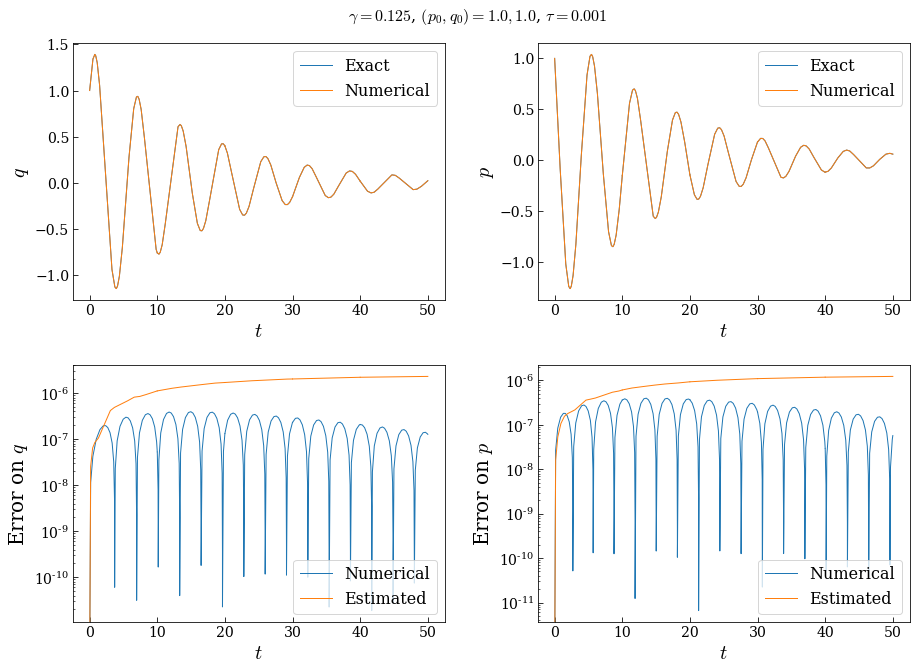

In [5]:
for t0, tf, dt in [(0.0, 50.0, 0.5), (0.0, 50.0, 0.001)]:
    tspan = np.arange(t0, tf, dt)
    steps = len(tspan)
    err = np.empty([steps], dtype=np.float64)

    for (alpha, p0, q0) in [(0.125, 1.0, 1.0)]: #,(0.2, 1.0, 1.0),(0.5, 1.0, 1.0), (1, 1.0, 1.0), (5, 1.0, 1.0)]:
        do = Osc(alpha)
        sol, _, _ = ic.integrate(ic.step, do, tspan, p0, q0, 0.0)
        ex = lambda tspan: exact(alpha, tspan)
        ex1 = lambda tspan: exactp(alpha, tspan)
        
        plt.figure(figsize=(15,10))
        plt.suptitle(f"$\\gamma = {do.alpha}$, $(p_0, q_0) = {p0}, {q0}$, $\\tau = {dt}$", size=16)

        ################
        plt.subplot(221)
        plt.plot(tspan, ex(tspan), linewidth=1, label="Exact")
        plt.plot(tspan, sol[:,1], linewidth=1, label="Numerical")
        plt.legend()
        plt.xlabel("$t$")
        plt.ylabel("$q$")

        ################
        plt.subplot(223)
        plt.plot(tspan, (abs(sol[:,1]-ex(tspan))), linewidth=1, label="Numerical")
        plt.plot(tspan, pad_and_cumsum([upper_error_bound(alpha, dt, p0, q0) for p0, q0 in sol[:]]), linewidth=1, label="Estimated")
        plt.legend(loc="lower right")
        plt.yscale('log')
        plt.xlabel("$t$")
        plt.ylabel("Error on $q$")


        ################
        plt.subplot(222)
        plt.plot(tspan, ex1(tspan), linewidth=1, label="Exact")
        plt.plot(tspan, sol[:,0], linewidth=1, label="Numerical")
        plt.legend()
        plt.xlabel("$t$")
        plt.ylabel("$p$")

        ################
        plt.subplot(224)
        plt.plot(tspan, (abs(sol[:,0]-ex1(tspan))), linewidth=1, label="Numerical")
        plt.plot(tspan, pad_and_cumsum([upper_error_bound_p(alpha, dt, p0, q0) for p0, q0 in sol[:]]), linewidth=1, label="Estimated")
        plt.legend(loc="lower right")
        plt.yscale('log')
        plt.xlabel("$t$")
        plt.ylabel("Error on $p$")
        
        plt.subplots_adjust(wspace=0.25, hspace=0.25, top=0.93)


    plt.show()

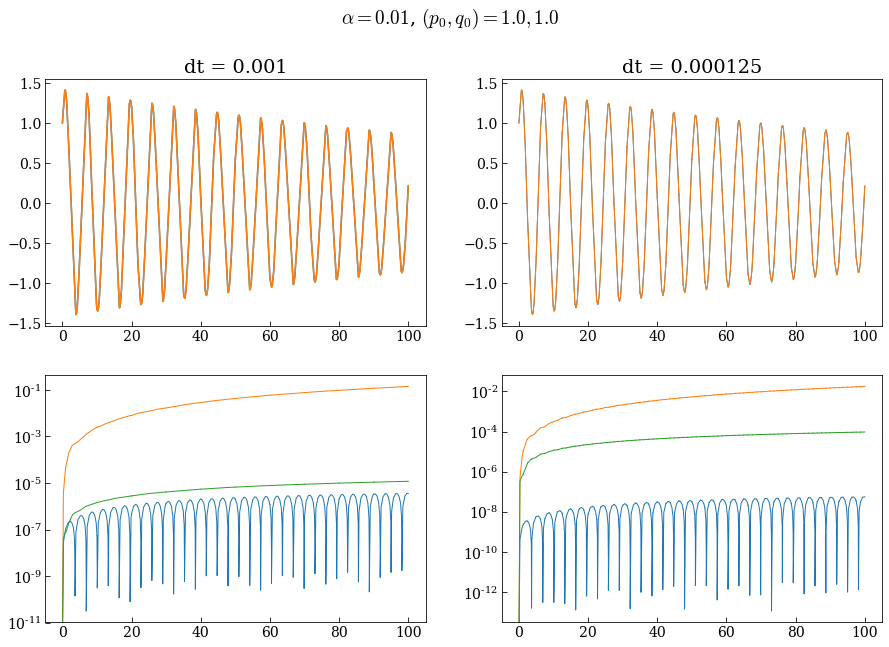

In [ ]:
t0, tf = (0.0, 100.0)
tspan = np.arange(t0, tf, dt)
tspansmall = np.arange(t0, tf, dt/8)
    
for (alpha, p0, q0) in [(0.01, 1.0, 1.0), (0.1, 1.0, 1.0), (1.0, 1.0, 1.0)]:
    do = Osc(alpha)
    
    plt.figure(figsize=(15,10))
    plt.suptitle(f"$\\alpha = {do.alpha}$, $(p_0, q_0) = {p0}, {q0}$")
    
    plt.subplot(221)
    plt.title(f"dt = {dt}")
    sol, _, _ = ic.integrate(ic.step, do, tspan, p0, q0, 0.0)
    solsmall, _, _ = ic.integrate(ic.step, do, tspansmall, p0, q0, 0.0)

    ex = lambda tspan: exact(alpha, tspan)
        
    plt.plot(tspan, ex(tspan))
    plt.plot(tspan, sol[:,1])

    plt.subplot(222)
    plt.title(f"dt = {dt/8}")
    plt.plot(tspansmall, ex(tspansmall), linewidth=1)
    plt.plot(tspansmall, solsmall[:,1], linewidth=1)

    plt.subplot(223)
    plt.plot(tspan, abs(sol[:,1]-ex(tspan)), linewidth=1)
    plt.plot(tspan, np.cumsum(abs(sol[:,1]-ex(tspan))), linewidth=1)
    plt.plot(tspan, pad_and_cumsum([upper_error_bound(alpha, dt, p0, q0) for p0, q0 in sol[:]]), linewidth=1)
    plt.yscale('log')

    plt.subplot(224)
    plt.plot(tspansmall, abs(solsmall[:,1]-ex(tspansmall)), linewidth=1)
    plt.plot(tspansmall, np.cumsum(abs(solsmall[:,1]-ex(tspansmall))), linewidth=1)
    plt.plot(tspansmall, pad_and_cumsum([upper_error_bound(alpha, dt, p0, q0) for p0, q0 in solsmall[:]]), linewidth=1)
    plt.yscale('log')
    plt.show()

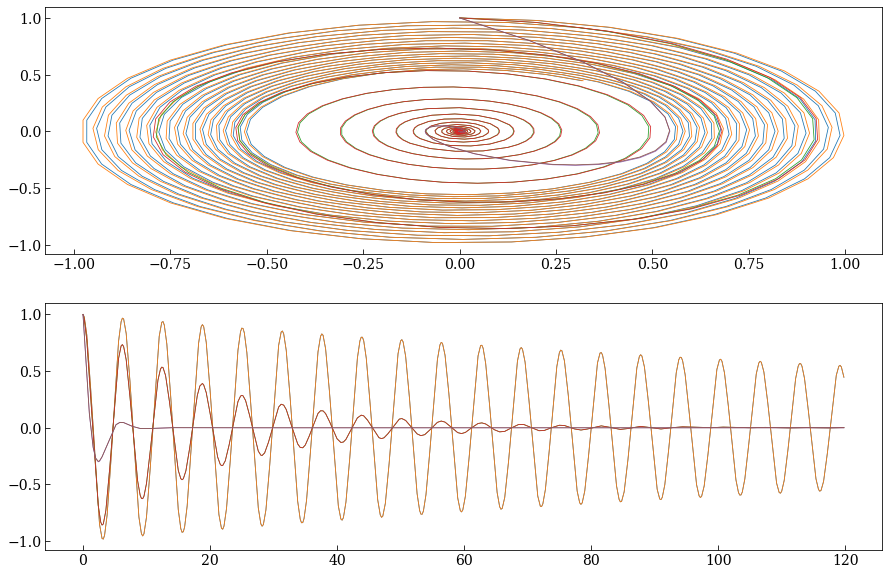

In [7]:
dt = 0.2
t0 = 0.0
tf = 120.0

tspan = np.arange(t0, tf, dt)

plt.figure(figsize=(15,10))

plt.subplot(211)
for (alpha, p0, q0) in [(0.01, 1.0, 0.0), (0.1, 1.0, 0.0), (1.0, 1.0, 0.0)]:
    do = Osc(alpha)
    
    sol, _, _ = ic.integrate(ic.step, do, tspan, p0, q0, 0.0)
    soll, _, _ = ic.integrate(ic.variational_step, do, tspan, p0, q0, 0.0)

    plt.plot(sol[:,1], sol[:,0], linewidth=0.8)
    plt.plot(soll[:,1], soll[:,0], linewidth=0.8)
    
plt.subplot(212)
for (alpha, p0, q0) in [(0.01, 1.0, 0.0), (0.1, 1.0, 0.0), (1.0, 1.0, 0.0)]:
    # FIXME: pointless to do it twice...
    sol, _, _ = ic.integrate(ic.step, do, tspan, p0, q0, 0.0)
    soll, _, _ = ic.integrate(ic.variational_step, do, tspan, p0, q0, 0.0)
        
    plt.plot(tspan, sol[:,0], linewidth=0.8)
    plt.plot(tspan, soll[:,0], linewidth=0.8)
plt.show()